# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data = pd.read_csv('./raw_data/retail_train.csv')
item_features = pd.read_csv('./raw_data/product.csv')
user_features = pd.read_csv('./raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=5)

[899624, 871756, 1044078, 1106523, 844179]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 937292, 1003616, 15778319]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[963686, 12523928, 945909, 1131625, 1101502]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

In [9]:
def popular_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [10]:
popular_recs = popular_recommendation(data_train_lvl_1, n=50)

In [11]:
#drop those users who are absent in train dataset
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1['user_id'].isin(data_train_lvl_1['user_id'])]

In [12]:
data_train_lvl_1 = data_train_lvl_1[data_train_lvl_1['user_id'].isin(data_val_lvl_1['user_id'])]

In [13]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [14]:
result_lvl_2 = result_lvl_1.copy()

In [15]:
# your_code
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_lvl_1['popular_recommendation'] = result_lvl_1['user_id'].apply(lambda x: popular_recs)
#result_lvl_1['similar_user'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [16]:
result_lvl_1.head()

,user_id,actual,als,own_recommendations,similar_items,popular_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[8090541, 9526630, 8293439, 856942, 5572884, 9...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1135983, 1007512, 9297615, 5577022, 1138474, ...","[999999, 1029743, 916122, 5569230, 1106523, 84..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 939681, 9487885, 1092835, 1009187, 1...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[999999, 1029743, 916122, 5569230, 1106523, 84..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[993685, 1082627, 1002771, 821741, 891423, 929...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[1038214, 999714, 897295, 999714, 6514160, 108...","[999999, 1029743, 916122, 5569230, 1106523, 84..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[878996, 1082185, 1026118, 871611, 896613, 857...","[13003092, 972416, 995598, 923600, 1138596, 10...","[948650, 5569845, 819308, 941361, 1074754, 110...","[999999, 1029743, 916122, 5569230, 1106523, 84..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[1060408, 7410336, 10285022, 7142937, 925579, ...","[998519, 894360, 7147142, 9338009, 896666, 939...","[893018, 1044078, 7147145, 880427, 872177, 965...","[999999, 1029743, 916122, 5569230, 1106523, 84..."


In [17]:
result_lvl_1.apply(lambda row: recall_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()

0.013632326831124812

In [18]:
result_lvl_1.apply(lambda row: recall_at_k(row['als'], row['actual']), axis=1).mean()

0.013448930449932096

In [19]:
result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual']), axis=1).mean()

0.018201887674891032

In [20]:
result_lvl_1.apply(lambda row: recall_at_k(row['similar_items'], row['actual']), axis=1).mean()

0.00635240451309648

In [21]:
#result_lvl_1.apply(lambda row: recall_at_k(row['similar_user'], row['actual']), axis=1).mean()

Дают ли own recommendtions + top-popular лучший recall? **Да дают**

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}

In [22]:
k_list = [5, 10, 20, 50, 100, 200, 500]
score = []
for k in k_list:
    score.append(result_lvl_1.apply(lambda row: recall_at_k(row['similar_items'], row['actual'], k=k), axis=1).mean())

In [23]:
score

[0.00635240451309648,
 0.01069091443996404,
 0.01851561915864054,
 0.03418888791152,
 0.03418888791152,
 0.03418888791152,
 0.03418888791152]

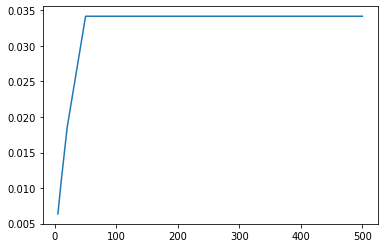

In [24]:
plt.plot(k_list, score)

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

50

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [25]:
# your_code
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [26]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [27]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1105426,1
0,2070,1097350,1
0,2070,879194,1
0,2070,948640,1


In [28]:
users_lvl_2.shape[0]

107550

In [29]:
users_lvl_2['user_id'].nunique()

2151

In [30]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [31]:
targets_lvl_2_val = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2_val['target'] = 1  # тут только покупки 

targets_lvl_2_val = users_lvl_2.merge(targets_lvl_2_val, on=['user_id', 'item_id'], how='left')

targets_lvl_2_val['target'].fillna(0, inplace= True)
targets_lvl_2_val.drop('flag', axis=1, inplace=True)

In [32]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


In [33]:
targets_lvl_2_val.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [34]:
targets_lvl_2['target'].mean()

0.10460593102333061

In [35]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [36]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [37]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [38]:
targets_lvl_2_val = targets_lvl_2_val.merge(item_features, on='item_id', how='left')
targets_lvl_2_val = targets_lvl_2_val.merge(user_features, on='user_id', how='left')

In [39]:
#Средний чек
average_basket = data_train_lvl_2.groupby(['user_id','basket_id'])['sales_value'].mean().reset_index()
average_basket.columns = ['user_id', 'basket_id', 'average_basket_price']
average_basket = average_basket.groupby('user_id')['average_basket_price'].mean().reset_index()

In [40]:
targets_lvl_2 = targets_lvl_2.merge(average_basket, on='user_id', how='left')

In [41]:
#Средний чек
average_basket_val = data_val_lvl_2.groupby(['user_id','basket_id'])['sales_value'].mean().reset_index()
average_basket_val.columns = ['user_id', 'basket_id', 'average_basket_price']
average_basket_val = average_basket_val.groupby('user_id')['average_basket_price'].mean().reset_index()

In [42]:
targets_lvl_2_val = targets_lvl_2_val.merge(average_basket_val, on='user_id', how='left')

In [43]:
#Частотность покупок раз/месяц
frequency = data_train_lvl_2.copy()
frequency['activity_per_month']=frequency['day']%30
frequency.drop_duplicates(subset ="basket_id", keep = False, inplace = True) 
frequency = frequency.groupby(['user_id', 'activity_per_month'])['basket_id'].count().reset_index()
frequency = frequency.groupby('user_id')['basket_id'].mean().reset_index()
frequency.columns = ['user_id', 'purchases_per_month']
frequency.head(2)

,user_id,purchases_per_month
0,1,1.0
1,2,1.0


In [44]:
targets_lvl_2 = targets_lvl_2.merge(frequency, on='user_id', how='left')

In [45]:
#Частотность покупок раз/месяц
frequency_val = data_val_lvl_2.copy()
frequency_val ['activity_per_month']=frequency_val['day']%30
frequency_val .drop_duplicates(subset ="basket_id", keep = False, inplace = True) 
frequency_val  = frequency_val .groupby(['user_id', 'activity_per_month'])['basket_id'].count().reset_index()
frequency_val  = frequency_val .groupby('user_id')['basket_id'].mean().reset_index()
frequency_val .columns = ['user_id', 'purchases_per_month']
frequency_val .head(2)

,user_id,purchases_per_month
0,1,1.0
1,6,1.0


In [46]:
targets_lvl_2_val = targets_lvl_2_val.merge(frequency, on='user_id', how='left')

In [47]:
#Кол-во покупок товара в неделю
item_per_week = data_train_lvl_2.groupby(['item_id','week_no'])['quantity'].sum().reset_index()
item_per_week = item_per_week.groupby('item_id')['quantity'].mean().reset_index()
item_per_week.columns = ['item_id', 'item_per_week']

In [48]:
targets_lvl_2 = targets_lvl_2.merge(item_per_week, on='item_id', how='left')

In [49]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_basket_price,purchases_per_month,item_per_week
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.18786,1.416667,1.666667
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.18786,1.416667,1.000000


In [50]:
#Кол-во покупок товара в неделю
item_per_week_val = data_val_lvl_2.groupby(['item_id','week_no'])['quantity'].sum().reset_index()
item_per_week_val = item_per_week_val.groupby('item_id')['quantity'].mean().reset_index()
item_per_week_val.columns = ['item_id', 'item_per_week']

In [51]:
targets_lvl_2_val = targets_lvl_2_val.merge(item_per_week, on='item_id', how='left')

In [52]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [53]:
X_val = targets_lvl_2_val.drop('target', axis=1)
y_val = targets_lvl_2_val[['target']]

In [54]:
cat_feats = X_train.select_dtypes(['object']).columns.tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')
X_train['manufacturer'] = X_train['manufacturer'].astype('category')

cat_feats.append('manufacturer')
cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'manufacturer']

In [55]:
cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'manufacturer']

In [56]:
cat_feats = X_val.select_dtypes(['object']).columns.tolist()
X_val[cat_feats] = X_val[cat_feats].astype('category')
X_val['manufacturer'] = X_val['manufacturer'].astype('category')

cat_feats.append('manufacturer')
cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'manufacturer']

In [370]:
lgb_params = { 
    'objective':'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 1,
    'learning_rate': 0.05134,
    'num_leaves': 4,
    'max_depth': 10,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'categorical_column': cat_feats,
    'random_state': 27,
    'silent': -1,
    'verbose': -1
}

# 'is_unbalance': True,
#'subsample_for_bin': 240000,

In [371]:
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_train, y_train.values.ravel())

train_preds = lgb.predict_proba(X_train)

In [372]:
train_preds = [item[0] for item in train_preds]
train_preds = pd.concat([X_train[['user_id','item_id' ]], pd.DataFrame(train_preds, columns=['probability'])], axis=1)

In [373]:
def get_top(df, user_id, top = 5):
    train_preds_sorted = train_preds[train_preds.user_id == user_id].sort_values("probability", axis = 0, ascending = False)
    predictions = train_preds_sorted['item_id'][:top].to_list()
    return predictions

In [374]:
result_lvl_2['lgbm_train'] = result_lvl_2['user_id'].apply(lambda x: get_top(train_preds, x, top=5))

In [375]:
val_preds = lgb.predict_proba(X_val)
val_preds = [item[0] for item in val_preds]
val_preds = pd.concat([X_val[['user_id','item_id' ]], pd.DataFrame(val_preds, columns=['probability'])], axis=1)

In [376]:
result_lvl_2['lgbm_val'] = result_lvl_2['user_id'].apply(lambda x: get_top(val_preds, x, top=5))

In [377]:
result_lvl_2.apply(lambda row: precision_at_k(row['lgbm_train'], row['actual']), axis=1).mean()

0.045560204556020785

In [378]:
result_lvl_2.apply(lambda row: precision_at_k(row['lgbm_val'], row['actual']), axis=1).mean()

0.045560204556020785

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 

**Внимание**
Позже будет добавлено требование по метрике MAP@5